<a href="https://colab.research.google.com/github/nasr98/DOC-CNN/blob/main/CNN_DOC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Document Classification

In [1]:
!pip install opencv-python
!pip install opendatasets
!pip3 install ann_visualizer
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import opendatasets as op
import cv2 as cv
import ann_visualizer as an
import graphviz as gv
import pathlib
import os
import keras

## Data Preparation

### Download Dataset

In [3]:
import shutil
op.download("https://www.kaggle.com/datasets/pdavpoojan/the-rvlcdip-dataset-test")
# try:
#   shutil.rmtree("/content/the-rvlcdip-dataset-test/test/scientific_publication")
# except FileNotFoundError:
#   print('Skip')

Skipping, found downloaded files in "./the-rvlcdip-dataset-test" (use force=True to force download)


### Prepare Tensor Dataset

In [4]:
data_dir = '/content/the-rvlcdip-dataset-test/test'

def create_dataset(path):
  dir_list = [x for x in os.listdir(path)]
  master = []
  label = []
  for x in dir_list:
    try:
      print(x)
      spec_path = path+'/'+x
      
      #Setting image size to 120,120, color to grey and normalize pixels
      img = [(cv.resize(cv.cvtColor(cv.imread(spec_path + '/' +y), cv.COLOR_BGR2GRAY), (120, 120)))/255.0 for y in os.listdir(spec_path) if np.shape(cv.imread(spec_path + '/' +y)) != ()]
      labels = [x for y in img]

      #extend master list with images and labels
      master.extend(img)
      label.extend(labels)
      del img
      del labels
    except TypeError:
      print(x)
  #Organize data in df
  t_df = pd.DataFrame(list(zip(label,master)),columns=['label','image'])
  #Convert DF to DS
  # t_ds = tf.data.Dataset.from_tensor_slices((list(t_df['image'].values), t_df['label'].values))
  return t_df

In [5]:
if os.path.exists("./rvlcdip.pkl"):
  df = pd.read_pickle("./rvlcdip.pkl")
else:
  df = create_dataset(data_dir)
  df.to_pickle("./rvlcdip.pkl")

resume
news_article
specification
file_folder
advertisement
memo
invoice
scientific_publication
email
letter
form
presentation
handwritten
budget
questionnaire
scientific_report


In [6]:
ds = tf.data.Dataset.from_tensor_slices((list(df['image'].values), df['label'].values))
ds

<TensorSliceDataset element_spec=(TensorSpec(shape=(120, 120), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

## EDA

### Sample Images

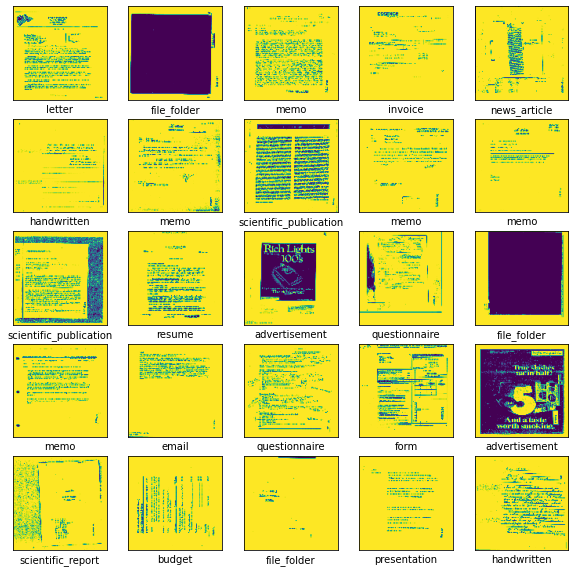

In [10]:
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

plt.figure(figsize=(10,10))
df1 = df.sample(frac=1).reset_index(drop=True)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(df1['image'][i])
    plt.xlabel(df1['label'][i])


### Images by label

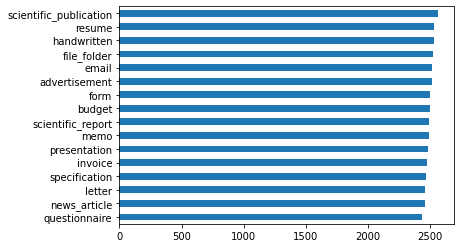

In [11]:
df['label'].value_counts().sort_values().plot(kind = 'barh',)

## Architecture Definition

### Convolution Base

In [59]:
df['image'][0].shape

(120, 120)

In [60]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(120,120))) # input layer

#hidden layer#
model.add(tf.keras.layers.MaxPooling2D((2, 2))) 
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
#############

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu')) # output layer

model.summary()

ValueError: ignored

### Dense Layers

In [ ]:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10))

In [ ]:
model.summary()

### Architecture Viz

In [61]:
from ann_visualizer.visualize import ann_viz
ann_viz(model, view=True, title="DOC CNN", filename='./doccnn.gv')

## Training

#### Splitting into Train,Test,Val

In [62]:
DATASET_SIZE = ds.cardinality().numpy()
train_size = int(0.7 * DATASET_SIZE)
test_size = int(0.3 * DATASET_SIZE)

In [63]:
ds = ds.shuffle(1000)
train = ds.take(train_size)
test = ds.skip(train_size)
val = test.skip(val_size)
test = test.take(test_size)

In [64]:
train = train.shuffle(1000).batch(32)
test = test.shuffle(1000).batch(32)
val = val.shuffle(1000).batch(32)

#### Compilation/Training

In [65]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [66]:
history = model.fit(train,epochs=10,validation_data=val)


Epoch 1/10


UnimplementedError: ignored